Epoch: 0, Loss: 1.0414320735223808e+16


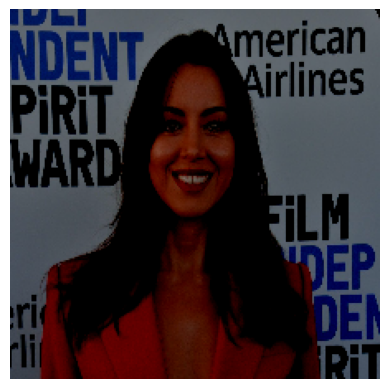

Epoch: 100, Loss: 1.1837609546350592e+16


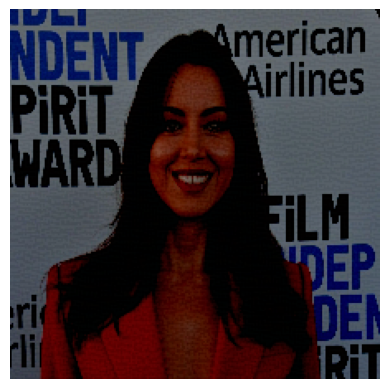

Epoch: 200, Loss: 1.055391039356928e+16


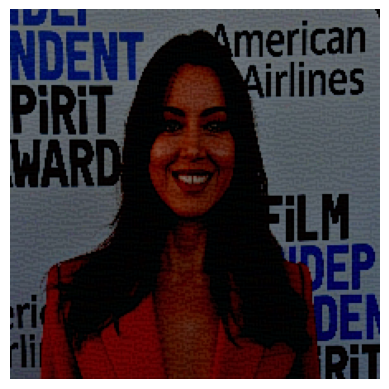

Epoch: 300, Loss: 9227473094967296.0


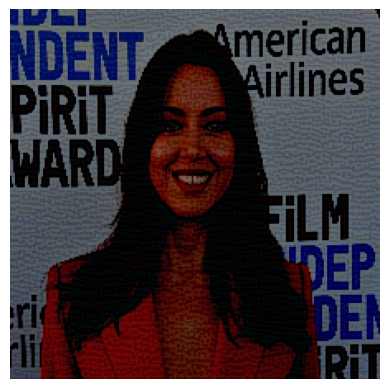

Epoch: 400, Loss: 7931641733316608.0


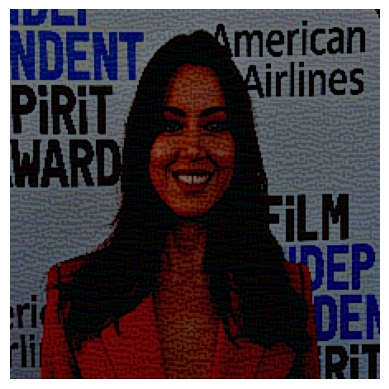

Epoch: 500, Loss: 6750142937956352.0


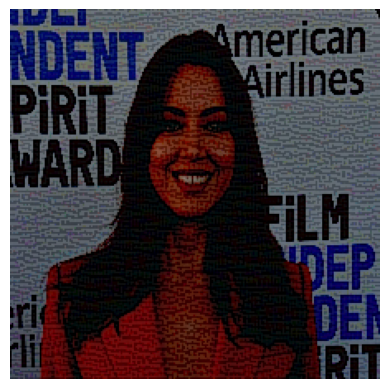

Epoch: 600, Loss: 5759449138462720.0


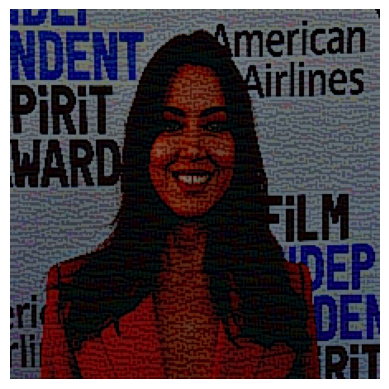

Epoch: 700, Loss: 4988697929842688.0


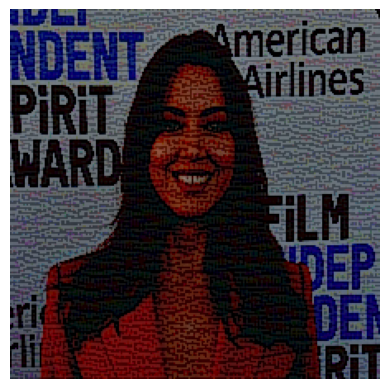

Epoch: 800, Loss: 4417418961092608.0


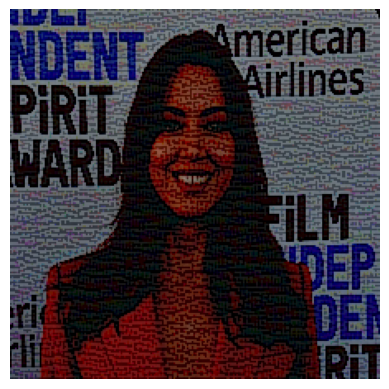

Epoch: 900, Loss: 4000344082219008.0


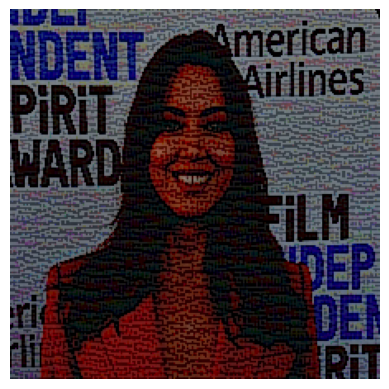

Epoch: 1000, Loss: 3687113191063552.0


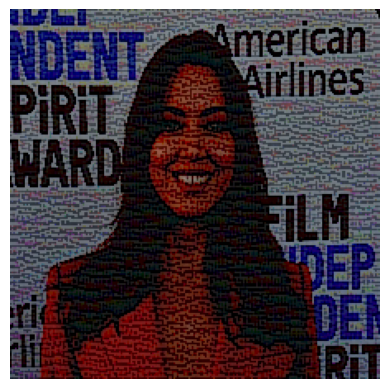

Epoch: 1100, Loss: 3438431631835136.0


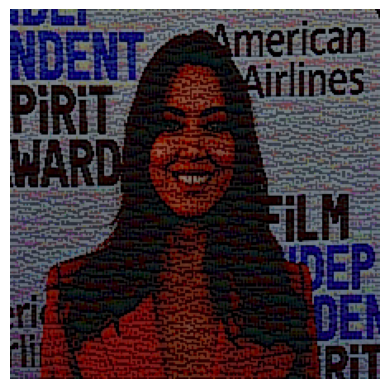

Epoch: 1200, Loss: 3229583478358016.0


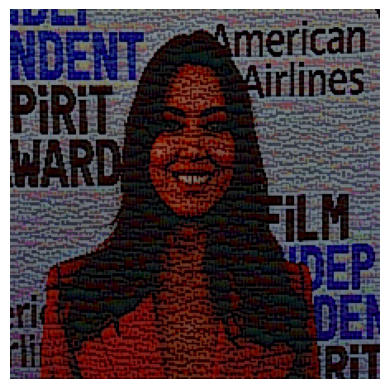

Epoch: 1300, Loss: 3047802208780288.0


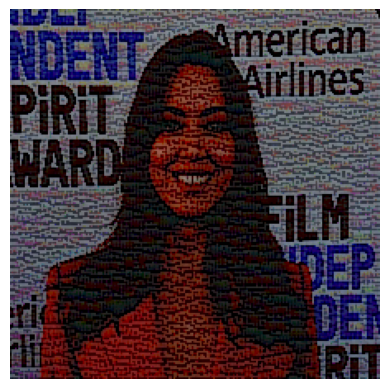

Epoch: 1400, Loss: 2886379352621056.0


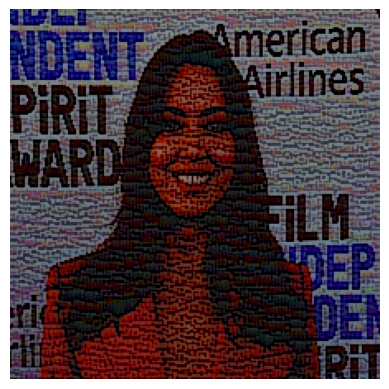

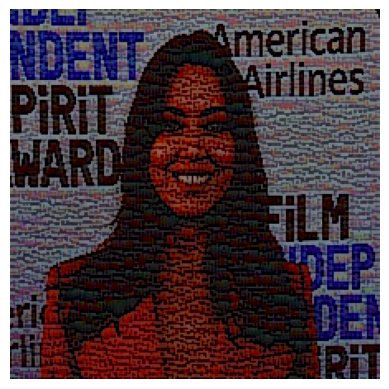

In [3]:
# 1. Import necessary libraries
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

# 2. Load and preprocess images
def load_and_process_image(image_path):
    img = kp_image.load_img(image_path, target_size=(224, 224))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img


content_image_path = 'C:\\Users\\ahmet\\Desktop\\JoJo\\AubreyPlaza.jpg'
style_image_path = 'C:\\Users\\ahmet\\Desktop\\JoJo\\brick.jpg'

content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

# 3. Create the model
def create_model(content_layer, style_layers):
    vgg = vgg16.VGG16(weights='imagenet', include_top=False)
    content_model = Model(inputs=vgg.input, outputs=vgg.get_layer(content_layer).output)
    style_models = [Model(inputs=vgg.input, outputs=vgg.get_layer(layer).output) for layer in style_layers]
    return content_model, style_models

content_layer = 'block4_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_model, style_models = create_model(content_layer, style_layers)

# 4. Define the loss functions
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram

def style_loss(style, generated):
    s_gram = gram_matrix(style)
    g_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(s_gram - g_gram))

def total_variation_loss(generated):
    x_var = generated[:, 1:, :, :] - generated[:, :-1, :, :]
    y_var = generated[:, :, 1:, :] - generated[:, :, :-1, :]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))

# 5. Set up the optimizer and fine-tune hyperparameters
optimizer = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)
content_weight = 1e4
style_weight = 1e-2
total_variation_weight = 1e4

# 6. Train the model and display the final generated image
@tf.function
def train_step(generated_image, content_image, style_images):
    with tf.GradientTape() as tape:
        content_generated = content_model(generated_image)
        style_generated = [style_model(generated_image) for style_model in style_models]

        c_loss = content_loss(content_image, content_generated)
        s_loss = sum(style_loss(style_image, gen_style) for style_image, gen_style in zip(style_images, style_generated))
        tv_loss = total_variation_loss(generated_image)

        total_loss = content_weight * c_loss + style_weight * s_loss + total_variation_weight * tv_loss

    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

    return total_loss


def bgr_to_rgb(img):
    return img[..., ::-1]



def train(content_features, style_image, epochs=1500, display_interval=100, save_directory='generated_images'):
    generated_image = tf.Variable(content_image, dtype=tf.float32)
    style_images = [style_model(style_image) for style_model in style_models]

    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    for epoch in range(epochs):
        total_loss = train_step(generated_image, content_features, style_images)

        if epoch % display_interval == 0:
            print(f'Epoch: {epoch}, Loss: {total_loss.numpy()}')

            current_image = bgr_to_rgb(generated_image.numpy())  # Convert to RGB
            plt.imshow(current_image[0] / 255.0)
            plt.axis('off')
            plt.show()

            save_path = os.path.join(
                save_directory, f'generated_image_epoch_{epoch}.jpg')
            plt.imsave(save_path, current_image[0] / 255.0)


    return generated_image.numpy()




# Extract content features before calling the train function
content_features = content_model(content_image)
final_image = train(content_features, style_image)
final_image_rgb = bgr_to_rgb(final_image)

plt.imshow(final_image_rgb[0] / 255.0)
plt.axis('off')
plt.show()


